# 2022-03-28 • The invariant measure: total stimulation

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


## Params & sim

Short warm-up run. Get compilation out of the way.

In [5]:
p0 = ExperimentParams(
    sim = SimParams(
        input = previous_N_30_input,
        duration = 1 * minutes
    )
);

In [6]:
@time sim(p0.sim);

  2.621567 seconds (7.21 M allocations: 512.827 MiB, 5.08% gc time, 92.06% compilation time)


In [32]:
p = ExperimentParams(
    sim = SimParams(
        input = realistic_N_6600_input,
        duration = 10 * minutes,
        synapses = SynapseParams(
            Δg_multiplier = 0.066,
        ),
        imaging = get_VI_params_for(
            cortical_RS,
            spike_SNR = Inf
        ),
    )
);
dumps(p)

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 5200
      N_inh: 1300
      N_conn: 6500
      N: 6600
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      Δg_exc: 4.0e-10
      Δg_inh: 1.6e-9
      Δg_multiplier: 0.066
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    rngseed: 22022022
  evaluation: EvaluationParams
    num_tested_neurons_per_group: 

In [33]:
t, v, vimsig, input_spikes, state = @time sim(p.sim);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:43
163.653968 seconds (18.23 M allocations: 2.300 GiB, 0.39% gc time, 0.00% compilation time)


In [34]:
num_spikes = length.(input_spikes)

ComponentVector{Int64}(conn = (exc = [1228, 940, 1389, 948, 509, 997, 831, 527, 1041, 876  …  1059, 997, 1200, 1103, 350, 585, 1106, 386, 1203, 798], inh = [470, 979, 876, 183, 882, 746, 1152, 1032, 201, 661  …  1287, 677, 865, 576, 1076, 1185, 1101, 1065, 927, 1334]), unconn = [908, 983, 717, 1052, 1400, 946, 680, 1444, 759, 612  …  1435, 868, 854, 329, 1235, 1300, 1394, 725, 505, 390])

## Plot

In [36]:
import PyPlot

In [37]:
using VoltageToMap.Plot

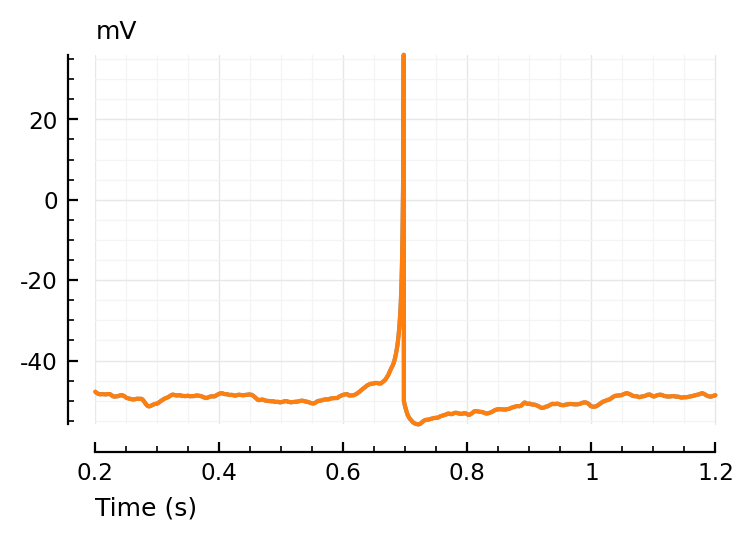

In [38]:
tzoom = [200, 1200]ms
ax = plotsig(t, vimsig / mV, tzoom; xlabel="Time (s)", hylabel="mV", alpha=0.7);
plotsig(t, v / mV, tzoom; ax);

(Perfect overlap of Vm and VI sig: ∞ SNR)

## Total stimulation

In [46]:
total_stim = num_spikes.conn .* state.fixed_at_init.Δg
round.(total_stim / nS)

ComponentVector{Float64}(exc = [32.0, 25.0, 37.0, 25.0, 13.0, 26.0, 22.0, 14.0, 27.0, 23.0  …  28.0, 26.0, 32.0, 29.0, 9.0, 15.0, 29.0, 10.0, 32.0, 21.0], inh = [50.0, 103.0, 93.0, 19.0, 93.0, 79.0, 122.0, 109.0, 21.0, 70.0  …  136.0, 71.0, 91.0, 61.0, 114.0, 125.0, 116.0, 112.0, 98.0, 141.0])

In [131]:
style = copy(sciplotlib_style)
style["xaxis.labellocation"] = "right"
set_mpl_style!(style);

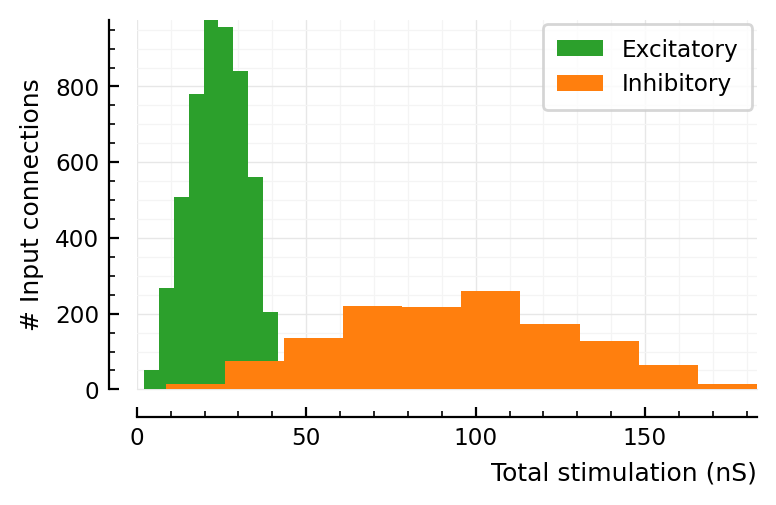

In [135]:
fig, ax = plt.subplots()
ax.hist(total_stim.exc / nS, color="C2", label="Excitatory")
ax.hist(total_stim.inh / nS, color="C1", label="Inhibitory")
ax.set_xlim(left=0)
set(ax, xlabel="Total stimulation (nS)", ylabel="# Input connections")
ax.legend();

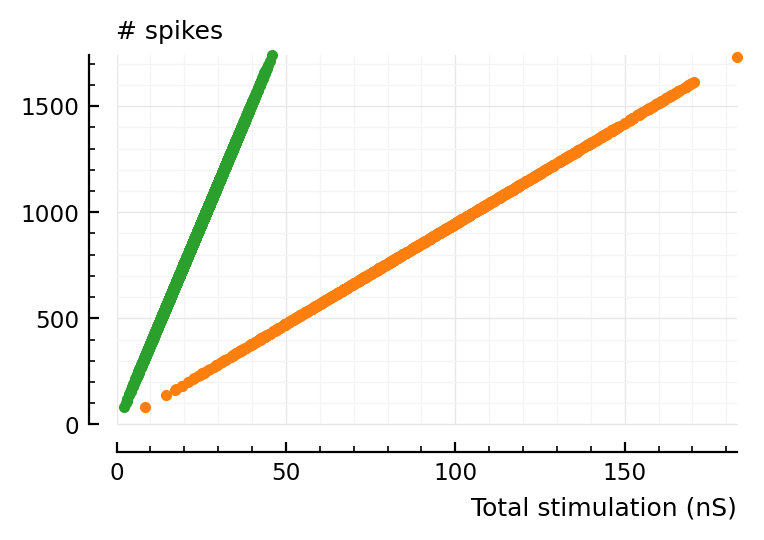

In [143]:
ax = plot(total_stim.exc / nS, num_spikes.conn.exc, "C2.", clip_on=false)
ax = plot(total_stim.inh / nS, num_spikes.conn.inh, "C1.", ax, clip_on=false)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
set(ax, hylabel="# spikes", xlabel="Total stimulation (nS)");

## p-values

Testing all input connections takes too long.
So we want to select only the most stimulating ones.

In [140]:
N_selected_per_class = 100;

In [99]:
get_indices_of_N_highest(arr, N) = partialsortperm(arr, 1:N, rev = true)  # = `maxk` in matlab

strongest_exc = get_indices_of_N_highest(total_stim.exc, N_selected_per_class)
strongest_inh = get_indices_of_N_highest(total_stim.inh, N_selected_per_class);

chosen_exc = strongest_exc
chosen_inh = strongest_inh;

No actually let's take random sample.

In [101]:
chosen_exc = 1:N_selected_per_class
chosen_inh = 1:N_selected_per_class;

In [102]:
total_stim__sel = CVec(
    exc = total_stim.exc[chosen_exc],
    inh = total_stim.inh[chosen_inh]
)
input_spike_trains__sel = (
    exc = input_spikes.conn.exc[chosen_exc],
    inh = input_spikes.conn.inh[chosen_inh],
);  # no CVec (as components are arrays, not scalars).

In [103]:
p_values = similar(total_stim__sel, Float64)

@showprogress 400ms for (i, presynspikes) in enumerate(input_spike_trains__sel.exc)
    p_values.exc[i] = test_connection(vimsig, presynspikes, p)
end
@showprogress 400ms for (i, presynspikes) in enumerate(input_spike_trains__sel.inh)
    p_values.inh[i] = 1 - test_connection(vimsig, presynspikes, p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


## Plot

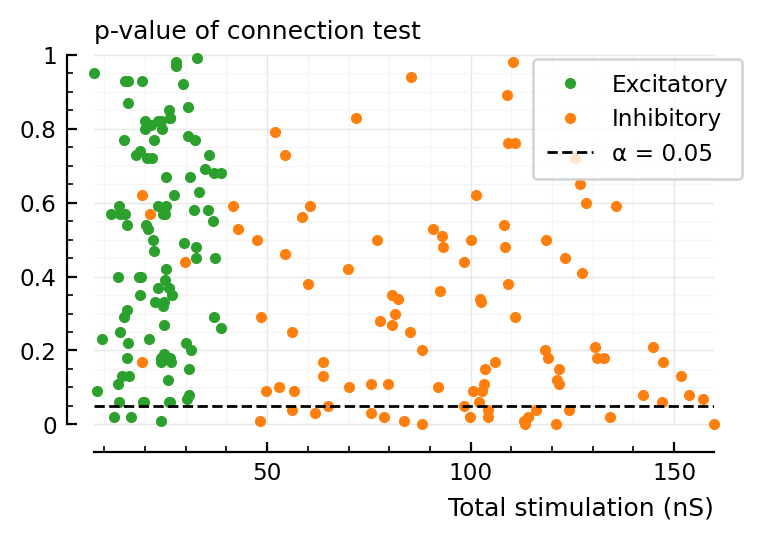

In [138]:
ax = plot(total_stim__sel.exc / nS, p_values.exc, "C2.", label="Excitatory", clip_on=false)
ax = plot(total_stim__sel.inh / nS, p_values.inh, "C1.", ax, label="Inhibitory", clip_on=false)
α = 0.05
ax.axhline(α, color="black", zorder=3, lw=1, linestyle="dashed", label=f"α = {α:.3G}")
set(ax, xlabel="Total stimulation (nS)", hylabel="p-value of connection test", ylim=[0,1])
ax.legend(loc="upper left", bbox_to_anchor=(0.7, 1));

^ is for a random selection of inputs.

The below is for the N strongest inputs:

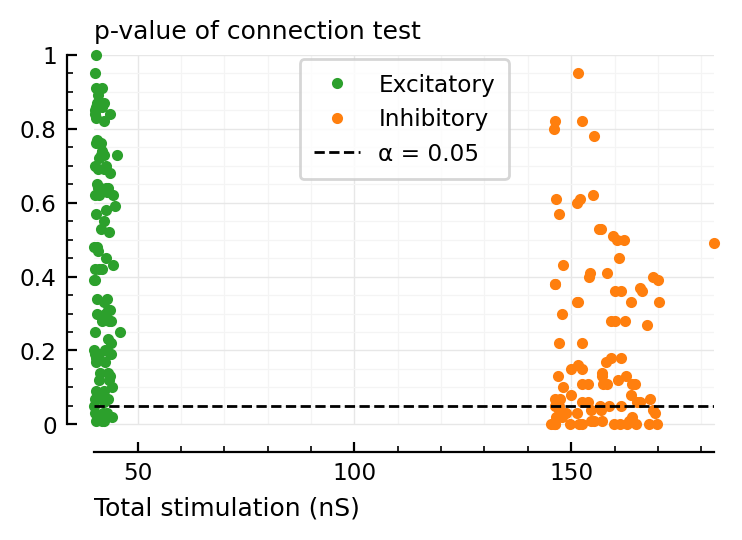

In [97]:
# (rerun and lose)